# 6. Analysis of the Collaborative Filtering Recommendation Model
Exploration of a collaborative filtering model based on the user_ratings data to recommend games to users and suggest similar games.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set display options and styling
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Create output directory for plots if it doesn't exist
import os
if not os.path.exists('../plots'):
    os.makedirs('../plots')
if not os.path.exists('../frames'):
    os.makedirs('../frames')

In [22]:
# Load user ratings data
user_ratings = pd.read_csv('../data/user_ratings.csv')

print(f"Loaded {len(user_ratings)} user ratings")

Loaded 18942215 user ratings


---

For the purposes of this analysis, we will filter the user ratings data to only include the most popular 1% of games and only users who have rated at least 50 of those top 1%. This helps us greatly reduce the size of our data, since there are so many users and so many games that the matrices we would perform calculations on would be incredibly large and incredibly sparse if we did not perform this filtering.

In [23]:
# Identify popular games (top N)
POPULARITY_THRESHOLD = 0.01  # fraction of top games

game_popularity = user_ratings['BGGId'].value_counts()
popular_threshold = int(len(game_popularity) * POPULARITY_THRESHOLD)
popular_games = game_popularity.nlargest(popular_threshold).index
print(f"Selected {len(popular_games)} popular games")

# Filter user_ratings to only include popular games
filtered_ratings = user_ratings[user_ratings['BGGId'].isin(popular_games)]

# Remove any duplicates
filtered_ratings = filtered_ratings.drop_duplicates(subset=['Username', 'BGGId'])

# Create the pivot table with popular games only
user_ratings_matrix = filtered_ratings.pivot(index='Username', columns='BGGId', values='Rating')
print(f"Unfiltered matrix shape: {user_ratings_matrix.shape}")

# Filter users who have rated at least 50 of these popular games
user_ratings_matrix = user_ratings_matrix.dropna(thresh=50, axis=0)
print(f"Matrix shape after user filtering: {user_ratings_matrix.shape}")

Selected 219 popular games
Unfiltered matrix shape: (332506, 219)
Matrix shape after user filtering: (35086, 219)


# Setup Collaborative Filtering Algorithm
Code adapted from our lab5 implementations.

In [25]:
def cosine_similarity(user1, user2):
    """Calculates the cosine similarity between two users."""
    common_ratings = (~np.isnan(user1)) & (~np.isnan(user2))
    if np.sum(common_ratings) == 0:
        return 0

    user1_common = user1[common_ratings]
    user2_common = user2[common_ratings]

    numerator = np.sum(user1_common * user2_common)
    denominator = np.sqrt(np.sum(user1_common ** 2) * np.sum(user2_common ** 2))

    if denominator == 0:
        return 0

    return numerator / denominator

In [36]:
def predict_rating(ratings, userIdx, itemIdx, k=50):
    """Predict the rating of a user for an item using a weighted sum of k nearest neighbors."""
    ratings = ratings.copy()

    user = ratings[userIdx]
    item = ratings[:, itemIdx]

    # if the user has already rated the item, set it to nan
    if not np.isnan(user[itemIdx]):
        ratings[userIdx, itemIdx] = np.nan

    user_mean = np.nanmean(user)

    # create list of similarities between the user and all other users
    similarities = np.array([cosine_similarity(user, other_user) for other_user in ratings])

    similarities[userIdx] = 0  # set similarity to self to 0 (ignore self)

    # find the nearest neighbors in the similarity list
    nn_indices = np.argsort(similarities)[::-1]
    if k is not None:
        # if there is a k, filter to k neighbors
        nn_indices = nn_indices[:k]
    rating_present_mask = ~np.isnan(ratings[nn_indices, itemIdx])
    filtered_indices = nn_indices[rating_present_mask]
    nn_sims = similarities[filtered_indices]

    # use the indices of the nearest neighbors to find their ratings for the item
    nn_ratings = ratings[filtered_indices, itemIdx]

    # adjust the ratings by subtracting each user's mean rating
    nn_means = np.array([np.nanmean(ratings[nn_index]) for nn_index in filtered_indices])
    nn_ratings = nn_ratings - nn_means

    # perform calculation for predicted rating using adjusted weighted sum formula
    numerator = np.sum(nn_sims * nn_ratings)
    denominator = np.sum(nn_sims)

    if denominator == 0:
        return user_mean
    else:
        prediction = user_mean + (numerator / denominator)
        # clip to 1-10 range
        return np.clip(prediction, 1, 10)

# Evaluation
Code adapted from our lab5 implementations.

In [39]:
def calculate_mae(tests, ratings):
    """Calculate the MAE of a method on a set of tests. Prints the results of each test
    and keeps track of the results in the confusion matrix."""
    running_ae = 0
    print("userID, itemID, Actual_Rating, Predicted_Rating, Delta_Rating")
    for user, item in tests:
        pred = predict_rating(ratings, user, item)
        actual = ratings[user, item]
        running_ae += np.abs(pred - actual)

        print(f"{user}, {item}, {actual}, {pred}, {np.abs(pred - actual)}")

    mae = running_ae / len(tests)
    return mae

def filter_valid(tests, ratings):
    """Given a list of tests, returns all valid tests."""
    valid_tests = []
    for user, item in tests:
        if np.isnan(ratings[user, item]):
            continue
        else:
            valid_tests.append((user, item))

    return valid_tests

def generate_tests(n_tests, ratings, item=None):
    """Randomly generate a set of validated user/item pairs for testing."""
    tests = []
    n_users, n_items = ratings.shape

    while len(tests) < n_tests:
        user = np.random.randint(n_users)
        if not item:
            item = np.random.randint(n_items)

        # tests is only added to if the user/item pair is valid
        tests += (filter_valid([(user, item)], ratings))

    return tests

def random_sampling(ratings, size=100, repeats=10):
    """Randomly sample user/item pairs for testing and calculate MAE."""
    MAEs = []

    for i in range(repeats):
        tests = generate_tests(size, ratings)

        mae = calculate_mae(tests, ratings)

        print(f"Overall MAE of testing run {i + 1}: {mae}")

        MAEs.append(mae)

    print(f"Mean Overall MAE: {np.mean(MAEs)}")
    print(f"Standard deviation of MAEs: {np.std(MAEs)}")

In [38]:
# Run evaluation
random_sampling(user_ratings_matrix.values, size=100, repeats=5)

userID, itemID, Actual_Rating, Predicted_Rating, Delta_Rating
27451, 5, 5.0, 6.950257257926033, 1.950257257926033
25429, 68, 6.7, 7.464439986856768, 0.7644399868567682
5042, 216, 7.0, 7.054011142912593, 0.0540111429125929
1503, 197, 8.0, 7.46913348070731, 0.5308665192926902
8436, 64, 5.0, 5.966239008645499, 0.9662390086454993
31179, 179, 6.0, 8.141631942752726, 2.141631942752726
4441, 162, 7.5, 8.473464410411125, 0.9734644104111254
18176, 208, 9.0, 7.619208702118406, 1.3807912978815944
10960, 72, 7.5, 7.915296757253927, 0.4152967572539268
3184, 21, 6.25, 7.308561650918499, 1.0585616509184987
13807, 33, 7.0, 7.189699630429126, 0.18969963042912585
26494, 33, 7.0, 7.084549758076793, 0.08454975807679332
10646, 159, 8.0, 7.751258909957459, 0.2487410900425413
27189, 43, 6.0, 6.633649107514886, 0.633649107514886
24917, 9, 7.25, 6.160853971730282, 1.0891460282697176
30086, 127, 8.0, 7.645528256940895, 0.3544717430591051
31347, 70, 6.0, 7.278018953923771, 1.2780189539237714
35081, 72, 5.0, 7.34

# Evaluation on a per-game basis

In [47]:
def random_sampling_per_game(ratings, game_ids, size=100):
        """Randomly sample user/item pairs for testing and calculate MAE."""
        games = range(ratings.shape[1])
        game_stats = {}

        for game in games:
            tests = generate_tests(size, ratings, item=game)
            mae = calculate_mae(tests, ratings)
            game_stats[game_ids[game]] = mae
            print(f"Overall MAE of testing run for game {game_ids[game]}: {mae}")

        for bggid, mae in game_stats.items():
            print(f"Game: {bggid}, MAE: {mae}")

        return game_stats

In [48]:
game_ids = user_ratings_matrix.columns.tolist()

game_stats = random_sampling_per_game(user_ratings_matrix.values, game_ids, size=10)

userID, itemID, Actual_Rating, Predicted_Rating, Delta_Rating
713, 212, 9.0, 7.140748962861775, 1.8592510371382254
30398, 212, 5.0, 8.115903232540733, 3.1159032325407328
10737, 212, 7.0, 6.571701054813512, 0.42829894518648803
5705, 212, 8.0, 6.419163527277079, 1.580836472722921
13521, 212, 6.5, 6.562918611498837, 0.06291861149883715
9414, 212, 7.0, 6.780886084264146, 0.21911391573585437
5554, 212, 4.0, 6.429858142387177, 2.429858142387177
10104, 212, 6.5, 6.643009468227493, 0.14300946822749339
30723, 212, 6.0, 6.635345817562047, 0.6353458175620474
17566, 212, 9.0, 7.179735993113097, 1.8202640068869034
Overall MAE of testing run for game 3: 1.2294799649886679
userID, itemID, Actual_Rating, Predicted_Rating, Delta_Rating
15403, 1, 7.0, 7.730595436302764, 0.7305954363027638
640, 1, 10.0, 8.788446757878356, 1.211553242121644
25306, 1, 7.0, 6.47470148977263, 0.52529851022737
34092, 1, 7.0, 5.038487098366136, 1.9615129016338644
6583, 1, 7.0, 7.014297604180882, 0.014297604180882217
18337, 1, 

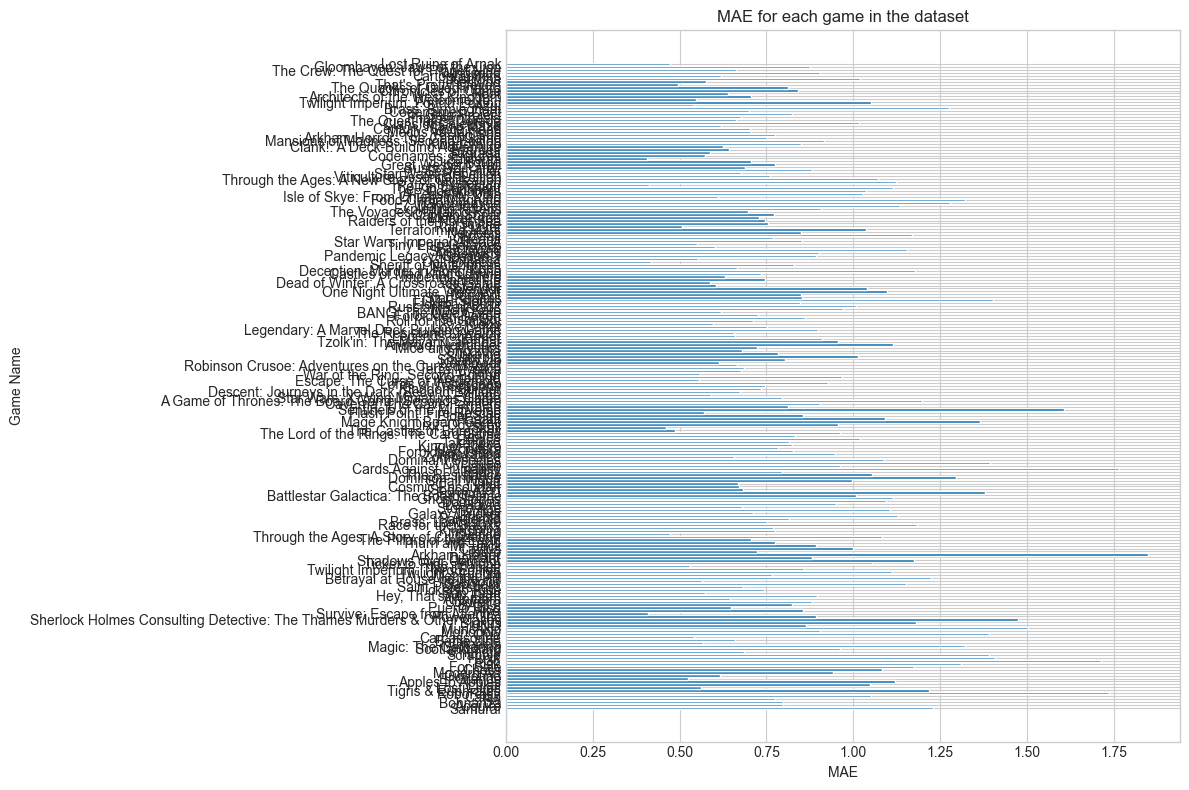

In [56]:
# Load games.csv to get the names of the games from their IDs
games = pd.read_csv('../data/games.csv')

# create a new dictionary mapping Game Name: MAE
game_mae = {games[games['BGGId'] == bggid]['Name'].values[0]: mae for bggid, mae in game_stats.items()}

# plot the MAEs for each game
plt.figure(figsize=(12, 8))
plt.barh(list(game_mae.keys()), list(game_mae.values()))
plt.xlabel('MAE')
plt.ylabel('Game Name')
plt.title('MAE for each game in the dataset')
plt.tight_layout()
plt.savefig('../plots/game_to_CF_mae.png')
plt.show()

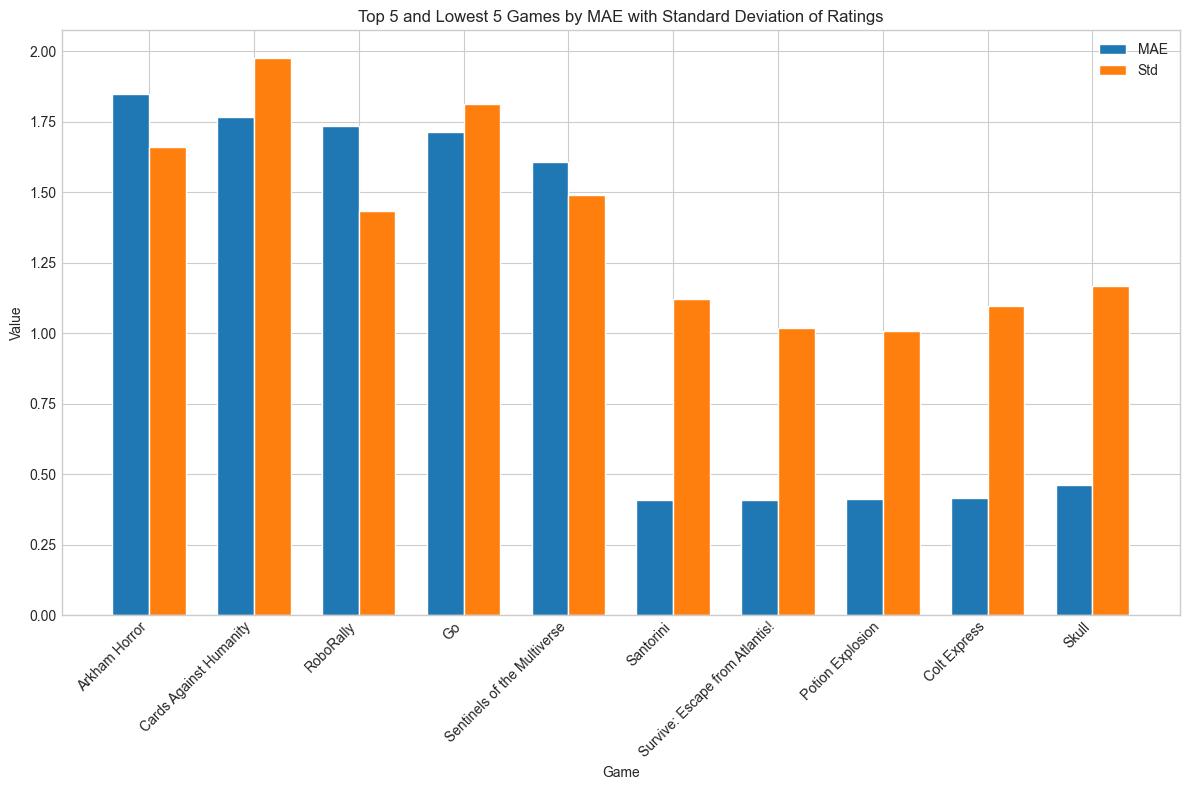

In [57]:
bggid_to_name = dict(zip(games['BGGId'], games['Name']))

# Compute standard deviation for each game in the user_ratings_matrix DataFrame
game_std = {bggid: np.nanstd(user_ratings_matrix[bggid]) for bggid in user_ratings_matrix.columns}

# map standard deviation values using the game name
game_std_named = {bggid_to_name.get(bggid, bggid): std for bggid, std in game_std.items() if bggid in game_stats}

# get the top 5 highest MAE games
top_5 = dict(sorted(game_mae.items(), key=lambda x: x[1], reverse=True)[:5])
top_5_std = [game_std_named[name] for name in top_5.keys()]

# get the lowest 5 MAE games
low_5 = dict(sorted(game_mae.items(), key=lambda x: x[1])[:5])
low_5_std = [game_std_named[name] for name in low_5.keys()]

# Combine top_5 and low_5: first list the top 5 games then the lowest 5 games
combined_keys = list(top_5.keys()) + list(low_5.keys())
combined_mae = [top_5.get(name, low_5.get(name)) for name in combined_keys]
combined_std = [game_std_named[name] for name in combined_keys]

# Define bar width and compute x positions for the 10 groups
bar_width = 0.35
indices = np.arange(len(combined_keys))

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(indices, combined_mae, bar_width, label='MAE')
ax.bar(indices + bar_width, combined_std, bar_width, label='Std')

ax.set_xlabel('Game')
ax.set_ylabel('Value')
ax.set_title('Top 5 and Lowest 5 Games by MAE with Standard Deviation of Ratings')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(combined_keys, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('../plots/top_low_CF_mae_std_ratings.png')
plt.show()

# Additional Analysis
Distribution of actual ratings, comparison of the model's predictions vs actuals, and distribution of user-user cosine similarities.

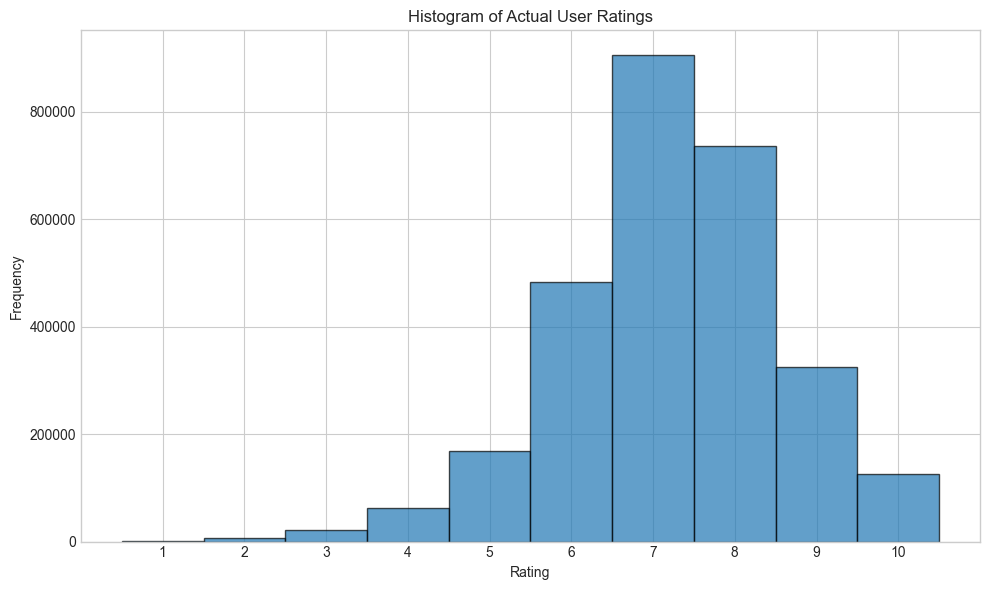

In [58]:
ratings_values = user_ratings_matrix.values.flatten()
ratings_values = ratings_values[~np.isnan(ratings_values)]

# histogram of actual ratings
plt.figure(figsize=(10, 6))
plt.hist(ratings_values, bins=range(1, 12), edgecolor='black', align='left', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Actual User Ratings')
plt.xticks(range(1, 11))
plt.tight_layout()
plt.savefig('../plots/actual_rating_distribution_hist.png')
plt.show()

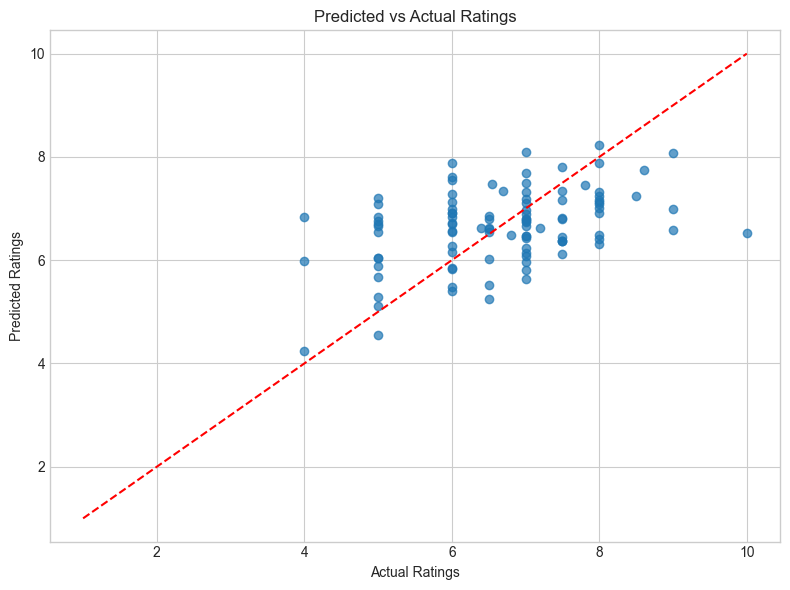

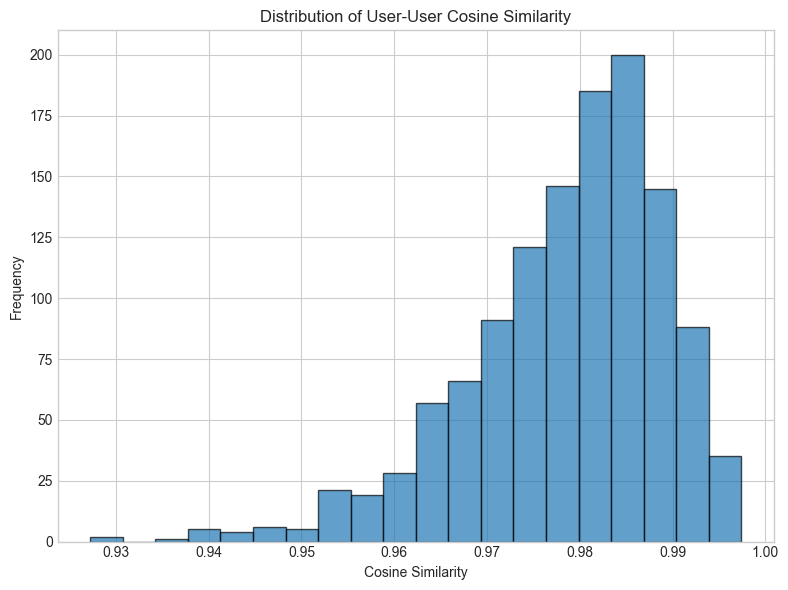

In [59]:
def calculate_rmse(tests, ratings):
    """Calculate RMSE and collect predicted and actual ratings."""
    running_se = 0
    predictions = []
    actuals = []
    for user, item in tests:
        pred = predict_rating(ratings, user, item)
        actual = ratings[user, item]
        predictions.append(pred)
        actuals.append(actual)
        running_se += (pred - actual) ** 2
    rmse = np.sqrt(running_se / len(tests))
    return rmse, np.array(predictions), np.array(actuals)

# Generate tests and compute RMSE
tests = generate_tests(100, user_ratings_matrix.values)
rmse, preds, acts = calculate_rmse(tests, user_ratings_matrix.values)

# Plot a scatter plot comparing predicted ratings vs. actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(acts, preds, alpha=0.7)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.grid(True)
plt.plot([1, 10], [1, 10], color="red", linestyle="--")  # perfect prediction line
plt.tight_layout()
plt.savefig('../plots/CF_ratings_predicted_vs_actual.png')
plt.show()

# Compute a distribution of user-user cosine similarities for a sample of users
def compute_user_similarities(ratings, sample_size=50):
    """Calculate cosine similarity for a sample of user pairs."""
    n_users = ratings.shape[0]
    similarities = []
    users = np.random.choice(np.arange(n_users), size=sample_size, replace=False)
    for i in users:
        for j in users:
            if i < j:
                sim = cosine_similarity(ratings[i], ratings[j])
                similarities.append(sim)
    return similarities

# Compute and plot histogram of similarities
sample_similarities = compute_user_similarities(user_ratings_matrix.values, sample_size=50)
plt.figure(figsize=(8, 6))
plt.hist(sample_similarities, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of User-User Cosine Similarity")
plt.tight_layout()
plt.savefig('../plots/user_cosine_similarity_hist.png')
plt.show()